In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sys
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\CT")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\3DTomoGAN")
from plots import *
import os
import utils
import h5py
from scipy.optimize import curve_fit
from PIL import Image

import scipy.ndimage as nd
import torch

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patheffects as PathEffects

%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [7]:
root = r"C:\Users\Bruker\Documents\appendix"
choose_formatter(False)

In [8]:
names = ["hourglassV3_13_55_2bin"]

oroot = r"/home/rubensd/Documents/DeepLearning/ReconstructionData"


x1, x2 = 0, 448
y1, y2 = 0, 264
z1, z2 = 0, 264


slice = [[x1, x2], [y1, y2], [z1, z2]]

identifiers = ["4D_4_fdk"]

indices = [x for x in range(0, 49, 4)]

crossections = {
}

keys = [str(i).zfill(5) for i in range(0, 49, 4)]

# Ignore parallel. Should take 0 seconds anyway.
for i in range(len(names)):
    for j in range(len(identifiers)):
        for idx in indices:

            load_name = f"{names[i]}_{identifiers[j]}_{str(idx).zfill(5)}_{x1}_{x2}_{y1}_{y2}_{z1}_{z2}.npy"
            load_path = os.path.join(root, load_name)
            crossections[str(idx).zfill(5)]= np.load(load_path)

In [9]:
def V3_revolution(nproj, rr, avgf, fps, add_on=5 ):
    """
    Calculates scan time of one revolution with GoldenRatioV3
    nproj: number of projections
    rr: rotation rate in degrees per second
    avgf: number of frames to average over
    fps: frames per second
    add_on: number of seconds to add on to the scan time
    """

    exposure = nproj * avgf/fps
    rot = 360/rr
    scan_time = exposure + rot + add_on

    exposure_ratio = exposure/scan_time
    return scan_time, exposure_ratio

def V3_angles(nproj, nrevs, starting=0):
    angles = np.zeros((nrevs, nproj))

    golden_angle_sampling = lambda n, inc: np.mod((n * 1/((np.sqrt(5) - 1) / 2) * inc), inc)

    startings = golden_angle_sampling(np.arange(starting,nrevs), 360/nproj)

    linear_sampling = lambda s: np.linspace(s, s + 360, nproj, endpoint=False)

    return linear_sampling(startings).T

def V3_total_time( rr, avgf, fps, add_on=5,nproj=None, nrevs=None,total = None):

    if total is None:
        total = nproj * nrevs
    elif nproj is None:
        nproj = total//nrevs
    elif nrevs is None:
        nrevs = total//nproj       
    else:
        raise ValueError
    
    scan_time_rev, exposure_ratio = V3_revolution(nproj, rr, avgf, fps, add_on)

    return scan_time_rev * nrevs, exposure_ratio

def standard_CT_time_exposure(nproj, rr, avgf, fps, add_on=0):
    return V3_revolution(nproj, rr, avgf, fps, add_on)

def theoretical_golden_angle(nproj, rr, avgf, fps, add_on=0 ):

    rotation = 137.5/rr
    exposure = avgf/fps
    scan_time = (rotation + exposure + add_on)*nproj
    exposure_ratio = nproj*exposure/scan_time
    return scan_time, exposure_ratio

def experimental_golden_angle(nproj, rr, avgf, fps, add_on=5):
    metallic_means = lambda n: (180* (n + np.sqrt(n**2 +4)))%360
    golden= metallic_means(1)
    golden = np.min([golden, np.abs(360-golden)])
    angles = np.arange(0, nproj* golden, golden)%360
    rotations = np.array([np.abs(angles[i] - angles[i-1]) for i in range(1, len(angles))])

    rotation = np.sum(rotations/rr)
    exposure = nproj*avgf/fps
    scan_time = rotation + exposure + add_on*nproj
    exposure_ratio = exposure/scan_time
    return scan_time, exposure_ratio

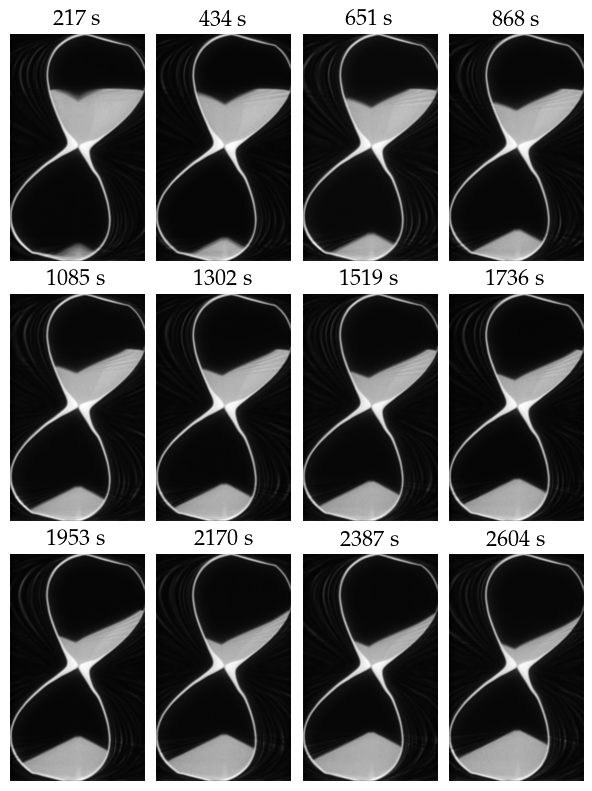

In [10]:
x1,x2, =0, 448
y1,y2 = 0, 264
z1,z2 = 158,159

slices = []
labels = []

for i,idx in enumerate(indices[:-1]):

    slices.append(crossections[str(idx).zfill(5)][x1:x2, y1:y2, z1:z2])

        #     nrevs = np.arange(1, 51)
    nproj = 13
    avg_frames = 12
    frames_per_sec = 10
    add_on = 5

    eff_rr = lambda rr, p: rr/21 * 12.75016391 * np.exp(-0.01348855 * p)
    effective_rotation_rate = eff_rr(21, nproj)


    V3_tots, V3_exps = V3_total_time(effective_rotation_rate, avg_frames, frames_per_sec, nproj=nproj, nrevs=(i+1)*4, add_on=add_on)

    # tot = V3_total_time()
    # labels.append(f"{(i+1)*4*49} s")
    labels.append(f"{V3_tots:.0f} s")

plot_slice_grid(
    slices,
    labels,
    fs = (2,1.5),
    ns=(3,4),
    folder = "Appendix",
    savefile = "fourD",
    savefig = False,

)




In [11]:
import torchio as tio
import imageio

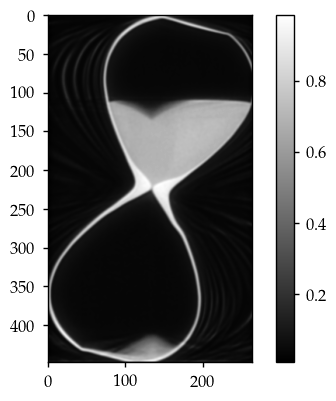

0.1609339


In [12]:
plt.imshow(crossections["00000"][x1:x2, y1:y2, z1:z2].squeeze(), cmap="gray")
plt.colorbar()
plt.show()

print(crossections["00000"][x1:x2, y1:y2, z1:z2].mean())

In [13]:
import plotly.graph_objects as go
import numpy as np
X, Y, Z = np.mgrid[-5:5:40j, -5:5:40j, -5:5:40j]

# ellipsoid
values = X * X * 0.5 + Y * Y + Z * Z * 2

# fig = go.Figure(data=go.Isosurface(
#     x=X.flatten(),
#     y=Y.flatten(),
#     z=Z.flatten(),
#     value=values.flatten(),
#     isomin=10,
#     isomax=40,
#     caps=dict(x_show=False, y_show=False)
#     ))
# fig.show()

In [22]:
def create_frame(im, t, idx):
    fig,ax = plt.subplots()
    ax.imshow(np.squeeze(im), cmap = 'gray')
    ax.set_axis_off()
    ax.set_title(f'{t}')
    plt.savefig(f'./gif/img_{idx}.png', 
                transparent = False,  
                facecolor = 'white'
               )
    plt.close()

def create_3D_frame(im, t, idx):

    im = im.transpose(2,1,0)

    x = np.arange(im.shape[0])
    y = np.arange(im.shape[1])
    z = np.arange(im.shape[2])
    X, Y, Z = np.meshgrid(x, y, z)

    fig = go.Figure(#data=go.Isosurface(
    data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=im.flatten(),
    opacity=0.3,
    opacityscale=[[0.4, 0], [0.6, 1], [0.7, 1], [0.85, 0.5]],
    isomin=0.1,
    isomax=1.1,
    surface_count=40,
    colorscale='gray',
    caps=dict(x_show=True, y_show=True),
    showscale=False,
    ))


    fig.update_layout(scene = dict(
                    xaxis = dict(
                        visible=False,
                        showticklabels=False,
                         backgroundcolor="rgb(255, 255, 255)",
                         gridcolor="white",
                         showbackground=False,
                         zerolinecolor="white",),
                    yaxis = dict(
                        visible=False,
                        showticklabels=False,
                        backgroundcolor="rgb(255, 255, 255)",
                        gridcolor="white",
                        showbackground=False,
                        zerolinecolor="white"),
                    zaxis = dict(
                        visible=False,
                        showticklabels=False,
                        backgroundcolor="rgb(255, 255, 255)",
                        gridcolor="white",
                        showbackground=False,
                        zerolinecolor="white",),),
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )
    fig.show()


In [23]:


adjusted = torch.nn.AvgPool3d((8,8,8), stride=(8,8,8))(torch.tensor(crossections[str(idx).zfill(5)]).unsqueeze(0).unsqueeze(0).float()).squeeze().numpy()



create_3D_frame(adjusted, 0,0)

In [15]:
for i,idx in enumerate(indices[:-1]):

    for j, r in enumerate(np.arange(0,361,30)):

        rotated = tio.RandomAffine(scales=(1,1), isotropic=True, degrees=(r,r,0,0,0,0), p=1)(crossections[str(idx).zfill(5)][np.newaxis])


        slices.append(rotated[:,x1:x2, y1:y2, z1:z2])

        #     nrevs = np.arange(1, 51)
        nproj = 13
        avg_frames = 12
        frames_per_sec = 10
        add_on = 5

        eff_rr = lambda rr, p: rr/21 * 12.75016391 * np.exp(-0.01348855 * p)
        effective_rotation_rate = eff_rr(21, nproj)


        V3_tots, V3_exps = V3_total_time(effective_rotation_rate, avg_frames, frames_per_sec, nproj=nproj, nrevs=(i+1)*4, add_on=add_on)

        labels.append(f"{V3_tots:.0f} s {r:.0f} deg")

        create_frame(slices[-1], labels[-1], i*12 + j)

    

In [16]:
frames = []
for t in range(145):
    image = imageio.v2.imread(f'./gif/img_{t}.png')
    frames.append(image)

In [17]:
imageio.mimsave('./gif/hourglass80.gif', # output gif
                frames,          # array of input frames
                duration = 80) 